In [ ]:
# !pip install pyspark

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

def get_path(dataset_name,env_name='colab'):
    prefix = 'https://raw.githubusercontent.com/John-Ghaly88/Big_Data_and_NoSQL/main/Datasets/Assessment/'
    if env_name == 'colab':
        return prefix+dataset_name
    else:
        return f'../Datasets/{dataset_name}'

## Reading the dataset

In [ ]:
df = pd.read_csv(get_path('music_genre_dataset.csv'))

df.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


# Data Preprocessing

## Exploring the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15517 entries, 0 to 15516
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         15517 non-null  object 
 1   Track Name          15517 non-null  object 
 2   Popularity          15123 non-null  float64
 3   danceability        15517 non-null  float64
 4   energy              15517 non-null  float64
 5   key                 13774 non-null  float64
 6   loudness            15517 non-null  float64
 7   mode                15517 non-null  int64  
 8   speechiness         15517 non-null  float64
 9   acousticness        15517 non-null  float64
 10  instrumentalness    11930 non-null  float64
 11  liveness            15517 non-null  float64
 12  valence             15517 non-null  float64
 13  tempo               15517 non-null  float64
 14  duration_in min/ms  15517 non-null  float64
 15  time_signature      15517 non-null  int64  
 16  Clas

In [ ]:
# df.describe()

## Data cleaning

### Dropping the Null values

In [ ]:
df.isnull().sum()

Artist Name              0
Track Name               0
Popularity             394
danceability             0
energy                   0
key                   1743
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      3587
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
# df.isnull().sum()

### Dropping the duplicate values

In [ ]:
df.drop_duplicates(keep = False, inplace = True)

## Data Featurization

 ### duration_in min/ms convert it duration_in_mins

In [ ]:
def convertToMins(t):
    s = str(t)
    #if it's in mins
    if((s[1]==".")or(s[2]==".")):
        return t
    #Else it's in milseconds, convert to mins by dividing the time by 60,000
    else:
        return t/60000

df['duration_in_mins'] = df['duration_in min/ms'].apply(lambda t:convertToMins(t))

#Dropping the duration_in min/ms column after adding the updated feature
df = df.drop(['duration_in min/ms'],axis=1)

### Renaming the Artist Name column because of the space

In [ ]:
df.rename(columns = {'Artist Name':'Artist'}, inplace = True)

In [ ]:
# df.head()

## Exporting the processed dataset

In [ ]:
# df.to_csv('processed_music_genre.csv',index=False)

# Spark SQL Queries

## Creating and defining the Spark session

In [ ]:
spark = SparkSession.builder.appName('music_genre').getOrCreate()

sdf = spark.createDataFrame(df)

sdf.createTempView("music")

## Query 1

In [ ]:
spark.sql("SELECT duration_in_mins FROM music").show()

+------------------+
|  duration_in_mins|
+------------------+
|           4.19555|
|1.8277833333333333|
| 3.832666666666667|
|3.4688833333333333|
|5.4897833333333335|
|       3.105783333|
|           3.96445|
|           4.33045|
|           4.44025|
|           2.56155|
|2.4466666666666668|
|           2.57155|
|4.7168833333333335|
|2.2978666666666667|
|               2.3|
|           5.16445|
| 4.289333333333333|
|3.4046666666666665|
|             3.286|
|            3.0137|
+------------------+
only showing top 20 rows



## Query 2

In [ ]:
spark.sql("SELECT Popularity,duration_in_mins FROM music").show()

+----------+------------------+
|Popularity|  duration_in_mins|
+----------+------------------+
|      54.0|           4.19555|
|      35.0|1.8277833333333333|
|      53.0| 3.832666666666667|
|      53.0|3.4688833333333333|
|      48.0|5.4897833333333335|
|      55.0|       3.105783333|
|      29.0|           3.96445|
|      11.0|           4.33045|
|      34.0|           4.44025|
|      76.0|           2.56155|
|      37.0|2.4466666666666668|
|      31.0|           2.57155|
|      48.0|4.7168833333333335|
|      44.0|2.2978666666666667|
|      29.0|               2.3|
|      44.0|           5.16445|
|      73.0| 4.289333333333333|
|      35.0|3.4046666666666665|
|      66.0|             3.286|
|      30.0|            3.0137|
+----------+------------------+
only showing top 20 rows



## Query 3

In [ ]:
spark.sql("SELECT Artist, AVG(Popularity) AS avg_p FROM music GROUP BY Artist ORDER BY avg_p  DESC LIMIT 5").show()

+--------------------+-----+
|              Artist|avg_p|
+--------------------+-----+
|       Doja Cat, SZA| 95.0|
|      Rauw Alejandro| 95.0|
|          Nio Garcia| 93.0|
|Riton, Nightcrawl...| 92.0|
|            Doja Cat| 91.5|
+--------------------+-----+



# Data Visualization

## Visualisation 1: The music tracks' duration range and distribution

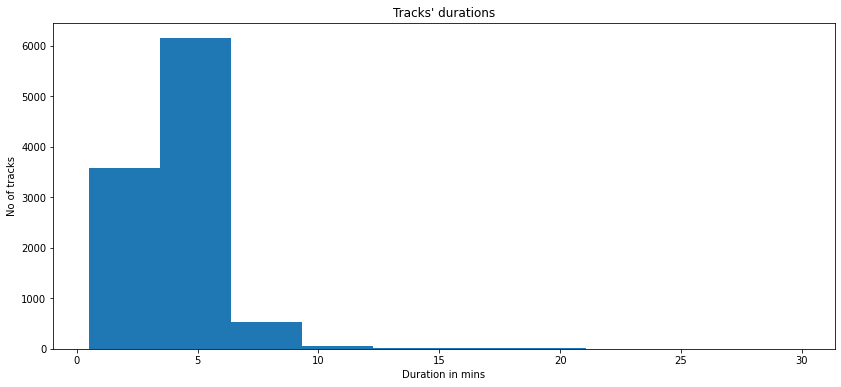

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Tracks' durations")
plt.xlabel('Duration in mins')
plt.ylabel('No of tracks')

plt.hist(df.duration_in_mins)

plt.show()

## Visualisation 2: A plot showing the co-relation between the popularity and the tracks' durations
## Does making longer tracks makes you more popular?

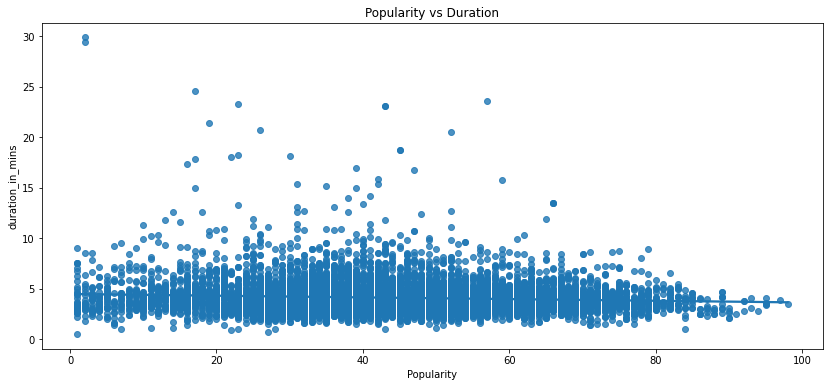

In [ ]:
plt.figure(figsize=(14,6))
plt.title('Popularity vs Duration')
plt.xlabel('Popularity')
plt.ylabel('Duration')

sns.regplot(x=df['Popularity'], y=df['duration_in_mins'])

plt.show()

## Visualisation 3: The most popular 5 artists

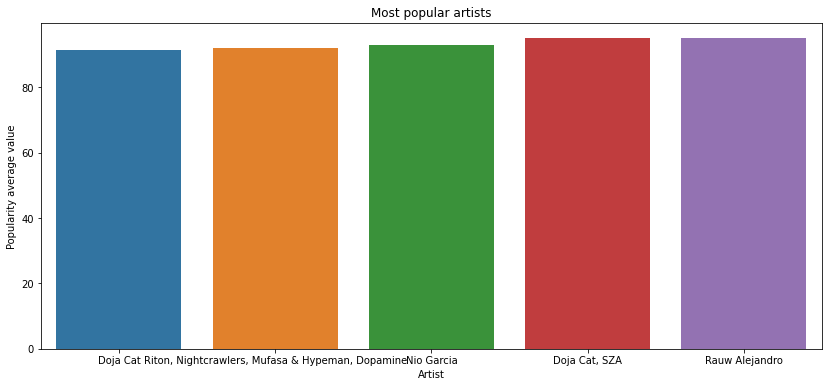

In [ ]:
plt.figure(figsize=(14,6))
plt.title('Most popular artists')
plt.xlabel('Artist Names')
plt.ylabel('Popularity average value')

groups = df.groupby('Artist')['Popularity'].mean().sort_values()[-5:]
sns.barplot(x=groups.index,y= groups.values)

plt.show()

# SparkML

In [ ]:
#Defining the features columns
numericCols = ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo','time_signature','duration_in_mins']

#Defining the pipeline
featurizationPipeline = Pipeline(stages = [VectorAssembler(inputCols = numericCols, outputCol = "feature_vector")])
featurizationPipelineModel = featurizationPipeline.fit(sdf)
sdf = featurizationPipelineModel.transform(sdf)

#Splitting the data into train and test
train, test = sdf.randomSplit([0.8, 0.2], seed = 2018)

## Classifier 1: Logistic Regression classifier

In [ ]:
#Training and applying the model
lr = LogisticRegression(featuresCol = 'feature_vector', labelCol = 'Class', maxIter=10)
lr_Model = lr.fit(train)
lr_predictions = lr_Model.transform(test)

#Extracting the labels and predictions
labels = lr_predictions.select('Class')
lr_predict = lr_predictions.select('prediction')

#Calculating accuracy of this classifier
lr_accuracy = accuracy_score(labels.toPandas(), lr_predict.toPandas())
print("Logistic Regression Accuracy =", lr_accuracy*100, "%")

Logistic Regression Accuracy = 42.84313725490196 %


## Classifier 2: Decision Trees

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'feature_vector', labelCol = 'Class')
dt_Model = dt.fit(train)
dt_predictions = dt_Model.transform(test)

labels = dt_predictions.select('Class')
dt_predict = dt_predictions.select('prediction')

dt_accuracy = accuracy_score(labels.toPandas(), dt_predict.toPandas())
print("Decision Tree Accuracy =", dt_accuracy*100, "%")

Decision Tree Accuracy = 38.2843137254902 %


## Classifier 3: Random Forests

In [ ]:
rf = RandomForestClassifier(featuresCol = 'feature_vector', labelCol = 'Class', numTrees=10)
rf_Model = rf.fit(train)
rf_predictions = rf_Model.transform(test)

labels = rf_predictions.select('Class')
rf_predict = rf_predictions.select('prediction')

rf_accuracy = accuracy_score(labels.toPandas(), rf_predict.toPandas())
print("Random Forest Accuracy =", rf_accuracy*100, "%")

Random Forest Accuracy = 39.26470588235294 %
